
### **This notebook is an adapted and modified from the NYU Deep Learning course (Spring 2020) by Alfredo Canziani and Yann LeCun**

[Please click here to access their more of their course material](https://atcold.github.io/pytorch-Deep-Learning/)

# In order to access a GPU to train your model on, you need to:
### From the menu above, select:
 - Select **Runtime**, 
 - Click **Change runtime type**
 - Select **GPU**.



---



---



# Outline

* Today we will show how to train a ConvNet using PyTorch
* We will also illustrate how the ConvNet makes use of specific assumptions

# To perform well, we need to incorporate some prior knowledge about the problem

* Assumptions helps us when they are true
* They hurt us when they are not
* We want to make just the right amount of assumptions, not more than that

## In Deep Learning

* Many layers: compositionality
* Convolutions: locality + stationarity of images
* Pooling: Invariance of object class to translations

In [1]:
#@title This cell contains some plotting functions that we will use later, run it by pressing the play button.
from IPython.display import HTML, display


def set_default(figsize=(10, 10), dpi=100):
    plt.style.use(['dark_background', 'bmh'])
    plt.rc('axes', facecolor='k')
    plt.rc('figure', facecolor='k')
    plt.rc('figure', figsize=figsize, dpi=dpi)


def plot_data(X, y, d=0, auto=False, zoom=1):
    X = X.cpu()
    y = y.cpu()
    plt.scatter(X.numpy()[:, 0], X.numpy()[:, 1], c=y, s=20, cmap=plt.cm.Spectral)
    plt.axis('square')
    plt.axis(np.array((-1.1, 1.1, -1.1, 1.1)) * zoom)
    if auto is True: plt.axis('equal')
    plt.axis('off')

    _m, _c = 0, '.15'
    plt.axvline(0, ymin=_m, color=_c, lw=1, zorder=0)
    plt.axhline(0, xmin=_m, color=_c, lw=1, zorder=0)


def plot_model(X, y, model):
    model.cpu()
    mesh = np.arange(-1.1, 1.1, 0.01)
    xx, yy = np.meshgrid(mesh, mesh)
    with torch.no_grad():
        data = torch.from_numpy(np.vstack((xx.reshape(-1), yy.reshape(-1))).T).float()
        Z = model(data).detach()
    Z = np.argmax(Z, axis=1).reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.3)
    plot_data(X, y)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy

# function to count number of parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

In [3]:
set_default()

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if device == 'cpu':
  print('You have not selected a GPU as instructed above.')

# Load the Dataset (MNIST)


We can use some PyTorch DataLoader utilities for this. This will download, shuffle, normalize data and arrange it in batches.

In [5]:
input_size  = 28*28   # images are 28x28 pixels
output_size = 10      # there are 10 classes

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=1000, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



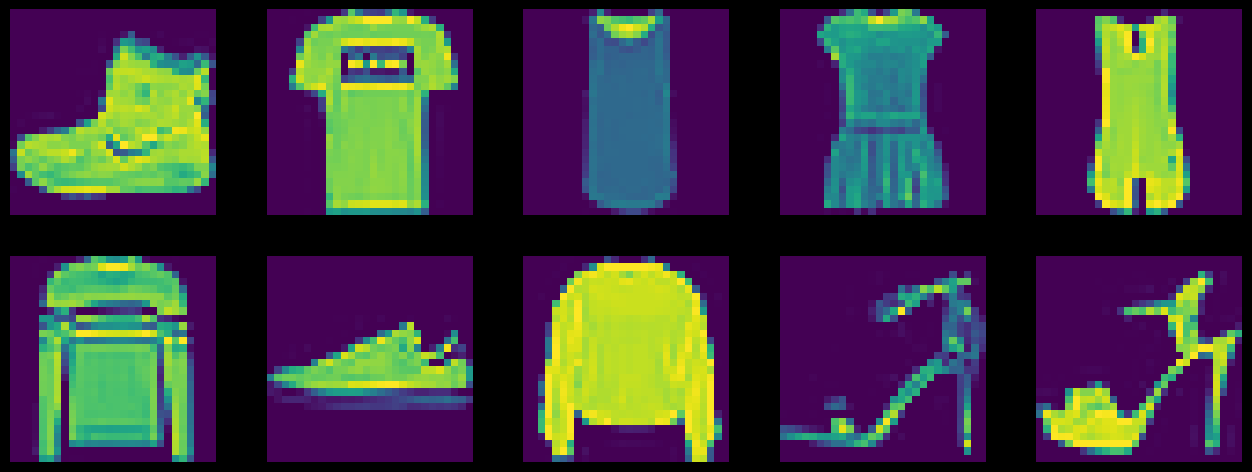

In [17]:
# show some images
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off');

# Create the model classes

In [8]:
class FC2Layer(nn.Module):
    def __init__(self, input_size, n_hidden, output_size):
        super(FC2Layer, self).__init__()
        self.input_size = input_size
        self.network = nn.Sequential(
            nn.Linear(input_size, n_hidden), 
            nn.ReLU(), 
            nn.Linear(n_hidden, n_hidden), 
            nn.ReLU(), 
            nn.Linear(n_hidden, output_size), 
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = x.view(-1, self.input_size)
        return self.network(x)
    
class CNN(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(CNN, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=n_feature, kernel_size=5)
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.fc1 = nn.Linear(n_feature*4*4, 50)
        self.fc2 = nn.Linear(50, 10)
        
    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, self.n_feature*4*4)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

## Running on a GPU: device string

Switching between CPU and GPU in PyTorch is controlled via a device string, which will seemlessly determine whether GPU is available, falling back to CPU if not:

In [9]:
accuracy_list = []

def train(epoch, model, perm=torch.arange(0, 784).long()):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # send to device
        data, target = data.to(device), target.to(device)
        
        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
def test(model, perm=torch.arange(0, 784).long()):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        # send to device
        data, target = data.to(device), target.to(device)
        
        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)
        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss                                                               
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_list.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))

# Train a small fully-connected network

In [10]:
n_hidden = 8 # number of hidden units

model_fnn = FC2Layer(input_size, n_hidden, output_size)
model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_fnn)))

for epoch in range(0, 1):
    train(epoch, model_fnn)
    test(model_fnn)

Number of parameters: 6442
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.297884
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.168484
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.841880
Train Epoch: 0 [19200/60000 (32%)]	Loss: 1.338409
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.928217
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.686171
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.675290
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.554661
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.414032
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.570709

Test set: Average loss: 0.5053, Accuracy: 8545/10000 (85%)



# Train a ConvNet with the same number of parameters

In [11]:
# Training settings 
n_features = 6 # number of feature maps

model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 1):
    train(epoch, model_cnn)
    test(model_cnn)

Number of parameters: 6422
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.304263
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.054548
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.516234
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.408611
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.411446
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.187113
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.389901
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.459999
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.357738
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.134939

Test set: Average loss: 0.1970, Accuracy: 9355/10000 (94%)



## We can visualise the filters that have been learnt by the CNN

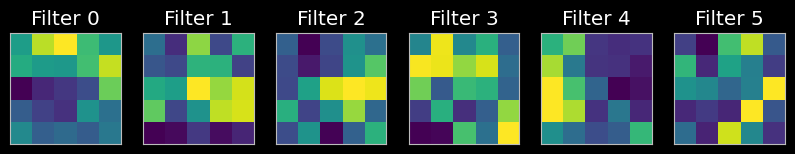

In [12]:
# Visualize conv filters in the first convolutional layer
kernels = model_cnn.conv1.weight.detach()
fig, axarr = plt.subplots(1,kernels.size(0))
for idx in range(kernels.size(0)):
    axarr[idx].imshow(kernels[idx].cpu().squeeze())
    axarr[idx].set_title(f'Filter {idx}')
    axarr[idx].get_xaxis().set_visible(False)
    axarr[idx].get_yaxis().set_visible(False)

## To see what these filters look like when we apply them on the input data, we can visualise a feature map:

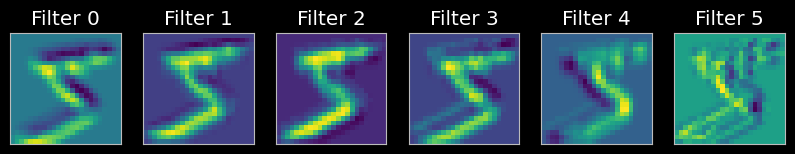

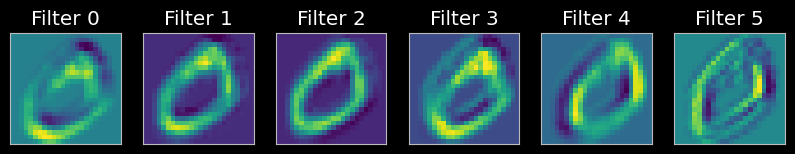

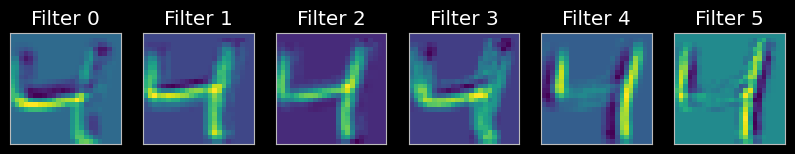

In [13]:
# Visualize feature maps
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model_cnn.conv1.register_forward_hook(get_activation('conv1'))

for i in range(3):
  data, _ = train_loader.dataset.__getitem__(i)
  data = data.to(device)
  data.unsqueeze_(0)
  output = model_cnn(data)
  act = activation['conv1'].squeeze()
  fig, axarr = plt.subplots(1,act.size(0))
  for idx in range(act.size(0)):
      axarr[idx].imshow(act[idx].cpu())
      axarr[idx].set_title(f'Filter {idx}')
      axarr[idx].get_xaxis().set_visible(False)
      axarr[idx].get_yaxis().set_visible(False)

# **Exercise 1**
Go back to the top of the notebook and change some variables and see what impact this has on the accuracy of classification

### Some to start you off, what happens when you change:
 - The number of filters `n_features`?
 - The number of epochs from 1 to 3?
 - The learning rate?



---



# The ConvNet performs better with the same number of parameters, thanks to its use of prior knowledge about images

* Use of convolution: Locality and stationarity in images
* Pooling: builds in some translation invariance

# What happens if the assumptions are no longer true?


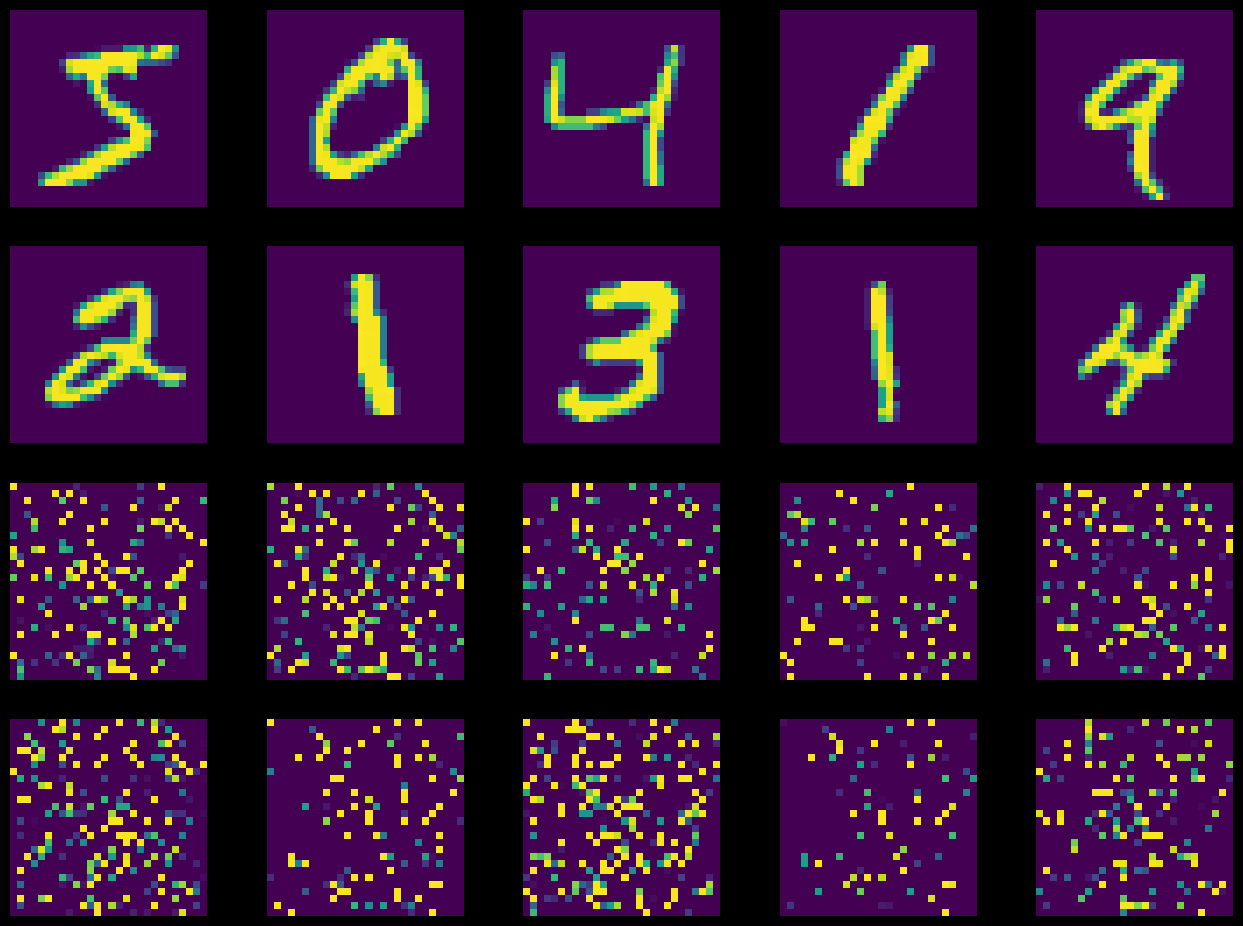

In [14]:
perm = torch.randperm(784)
plt.figure(figsize=(16, 12))
for i in range(10):
    image, _ = train_loader.dataset.__getitem__(i)
    # permute pixels
    image_perm = image.view(-1, 28*28).clone()
    image_perm = image_perm[:, perm]
    image_perm = image_perm.view(-1, 1, 28, 28)
    plt.subplot(4, 5, i + 1)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off')
    plt.subplot(4, 5, i + 11)
    plt.imshow(image_perm.squeeze().numpy())
    plt.axis('off')

# ConvNet with permuted pixels

In [15]:
# Training settings 
n_features = 6 # number of feature maps

model_cnn_perm = CNN(input_size, n_features, output_size)
model_cnn_perm.to(device)
optimizer = optim.SGD(model_cnn_perm.parameters(), lr=0.01, momentum=0.5)
print(f'Number of parameters: {get_n_params(model_cnn_perm)}')

for epoch in range(0, 1):
    train(epoch, model_cnn_perm, perm)
    test(model_cnn_perm, perm)

Number of parameters: 6422
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.317846
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.266737
Train Epoch: 0 [12800/60000 (21%)]	Loss: 2.048970
Train Epoch: 0 [19200/60000 (32%)]	Loss: 1.566203
Train Epoch: 0 [25600/60000 (43%)]	Loss: 1.054734
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.982699
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.662207
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.562835
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.406179
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.564931

Test set: Average loss: 0.5406, Accuracy: 8306/10000 (83%)



# Fully-Connected with Permuted Pixels

In [ ]:
n_hidden = 8    # number of hidden units

model_fnn = FC2Layer(input_size, n_hidden, output_size)
model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)
print(f'Number of parameters:{get_n_params(model_fnn)}')

for epoch in range(0, 1):
    train(epoch, model_fnn, perm)
    test(model_fnn, perm)

Number of parameters:6442
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.336949
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.114641
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.591759
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.850225
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.672639
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.660765
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.539101
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.798375
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.434800
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.547865

Test set: Average loss: 0.4878, Accuracy: 8589/10000 (86%)



# The ConvNet's performance drops when we permute the pixels, but the Fully-Connected Network's performance stays the same

* ConvNet makes the assumption that pixels lie on a grid and are stationary/local
* It loses performance when this assumption is wrong
* The fully-connected network does not make this assumption
* It does less well when it is true, since it doesn't take advantage of this prior knowledge
* But it doesn't suffer when the assumption is wrong

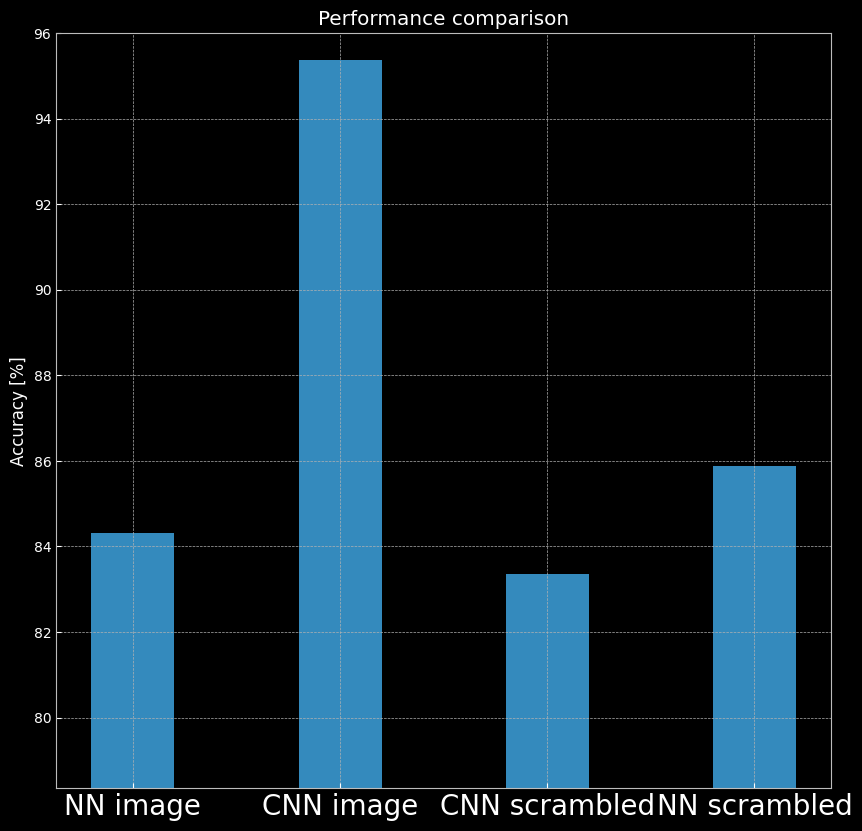

In [ ]:
plt.bar(('NN image', 'CNN image',
         'CNN scrambled', 'NN scrambled'),
        accuracy_list, width=0.4)
plt.ylim((min(accuracy_list)-5, 96))
plt.ylabel('Accuracy [%]')
for tick in plt.gca().xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
plt.title('Performance comparison');

# **Exercise 2**
Another cool data set is the FashionMNIST one which contains images for 10 different types of clothing. The code below gets the data and makes some plots. It has excatly the same structure as MNIST. 

Use the above code, write a CNN to classifiy the images.

In [20]:
input_size  = 28*28   # images are 28x28 pixels
output_size = 10      # there are 10 classes

train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=1000, shuffle=True)

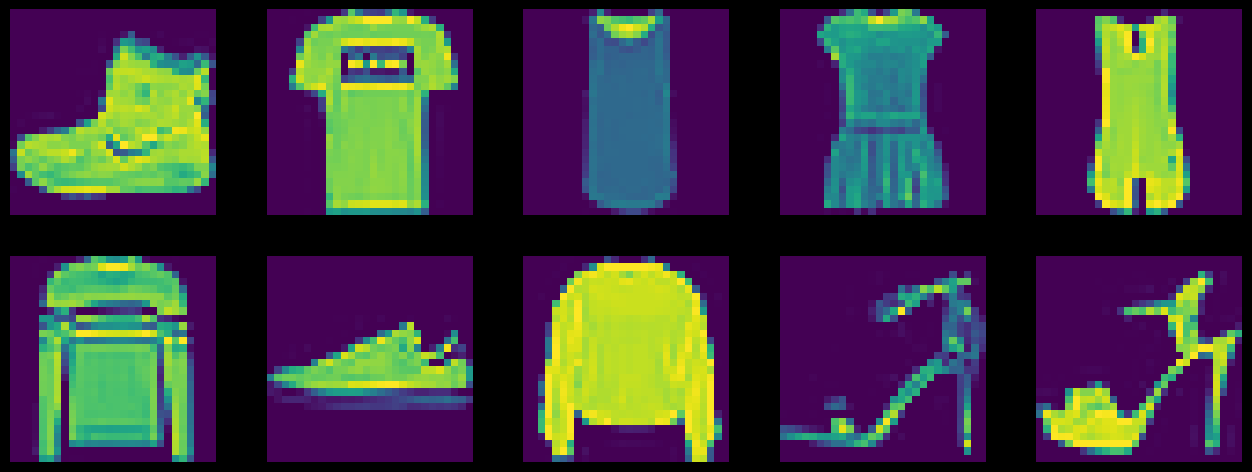

In [21]:
# show some images
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off');